# Variational autoencoder for MNIST

## Learning Objectives
1. learn how Variational Autoencoder works
2. Learn how to build Variational Autoencoder in Keras Functional API

## Preparation
### Import Dependencies


In [1]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(threshold=np.inf)

### Visualization utilities

In [2]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


def plot_label_clusters(encoder, data, labels, vae=True):
    # display a 2D plot of the digit classes in the latent space
    if vae:
        z_mean, _, _ = encoder.predict(data)
    else:
        z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10):  # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(
            cx, cy, str(label), color="white", fontsize=25, fontweight="bold"
        )
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


### Load MNIST Data

Use Keras utilities to load MNIST data

In [3]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

## Build Variational Autoencoder

This is similar to autoencoder except that we sample the mean and variance of the latent dimension.

### Sampling layer
The variational encoder uses (z_mean, z_log_var) to sample the vector that encodes a digit.

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder
The encoder goes from the inputs to the latent dim, but because we have multiple outputs, we have to use the functional style

In [5]:
latent_dim = (
    2  # for easy visualization. Specify larger value for better performance
)

encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
x = layers.Conv2D(
    32, 3, activation="relu", strides=2, padding="same", name="e_conv1"
)(encoder_inputs)
x = layers.Conv2D(
    64, 3, activation="relu", strides=2, padding="same", name="e_conv2"
)(x)
x = layers.Flatten(name="e_flatten")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)  # the autoencoder output
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()(z_mean, z_log_var)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

2022-04-20 05:38:47.788340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 05:38:47.798347: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 05:38:47.799024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
e_conv1 (Conv2D)                (None, 14, 14, 32)   320         image_input[0][0]                
__________________________________________________________________________________________________
e_conv2 (Conv2D)                (None, 7, 7, 64)     18496       e_conv1[0][0]                    
__________________________________________________________________________________________________
e_flatten (Flatten)             (None, 3136)         0           e_conv2[0][0]                    
____________________________________________________________________________________________

2022-04-20 05:38:47.800606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-20 05:38:47.801544: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 05:38:47.802175: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-20 05:38:47.802702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

### Decoder
The decoder goes from the latent dim back to the reconstructed image:

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,), name="d_input")
x = layers.Dense(7 * 7 * 64, activation="relu", name="d_d1")(latent_inputs)
x = layers.Reshape((7, 7, 64), name="d_d2")(x)
x = layers.Conv2DTranspose(
    32, 3, activation="relu", strides=2, padding="same", name="d_conv1"
)(x)
decoder_outputs = layers.Conv2DTranspose(
    1, 3, activation="sigmoid", strides=2, padding="same", name="d_conv2"
)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
d_d1 (Dense)                 (None, 3136)              9408      
_________________________________________________________________
d_d2 (Reshape)               (None, 7, 7, 64)          0         
_________________________________________________________________
d_conv1 (Conv2DTranspose)    (None, 14, 14, 32)        18464     
_________________________________________________________________
d_conv2 (Conv2DTranspose)    (None, 28, 28, 1)         289       
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


## Loss Function

### Latent Loss: Kullback-Leibler Divergence
The encoder's loss is KL divergence.

In [7]:
def kl_divergence(z_mean, z_log_var):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))


encoder.add_loss(kl_divergence(z_mean, z_log_var))

The autoencoder consists of the encoder and the decoder blocks. We can write it as a Keras Functional model

In [8]:
z_mean, z_log_var, z = encoder(encoder_inputs)  # 3 outputs now
decoder_output = decoder(z)
vae = keras.Model(encoder_inputs, decoder_output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         [(None, 2), (None, 2), (N 31364     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         28161     
Total params: 59,525
Trainable params: 59,525
Non-trainable params: 0
_________________________________________________________________


### Reconstruction Loss: Pixel-wise Cross Entropy
The overall reconstruction loss is the sum of binary per-pixel losses

In [9]:
def reconstruction_loss(real, reconstruction):
    return tf.reduce_mean(
        tf.reduce_sum(
            keras.losses.binary_crossentropy(real, reconstruction), axis=(1, 2)
        )
    )


vae.compile(
    optimizer=keras.optimizers.Adam(), loss=reconstruction_loss, metrics=["mse"]
)

In [10]:
history = vae.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

2022-04-20 05:38:49.168855: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-20 05:38:50.501053: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


547/547 [==============================] - 6s 5ms/step - loss: 213.2208 - mse: 0.0682
Epoch 2/30
547/547 [==============================] - 3s 5ms/step - loss: 169.0835 - mse: 0.0504
Epoch 3/30
547/547 [==============================] - 3s 5ms/step - loss: 163.9398 - mse: 0.0479
Epoch 4/30
547/547 [==============================] - 3s 5ms/step - loss: 161.2024 - mse: 0.0466
Epoch 5/30
547/547 [==============================] - 3s 5ms/step - loss: 159.6835 - mse: 0.0458
Epoch 6/30
547/547 [==============================] - 3s 5ms/step - loss: 158.5656 - mse: 0.0453
Epoch 7/30
547/547 [==============================] - 3s 5ms/step - loss: 157.8211 - mse: 0.0449
Epoch 8/30
547/547 [==============================] - 3s 5ms/step - loss: 157.1223 - mse: 0.0445
Epoch 9/30
547/547 [==============================] - 3s 5ms/step - loss: 156.5934 - mse: 0.0443
Epoch 10/30
547/547 [==============================] - 3s 5ms/step - loss: 156.0897 - mse: 0.0440
Epoch 11/30
547/547 [===================

## Visualize the latent space

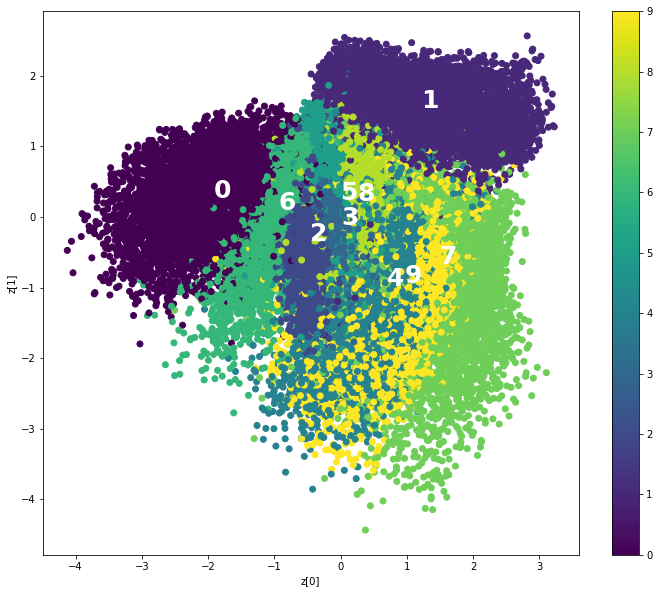

In [11]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=True)

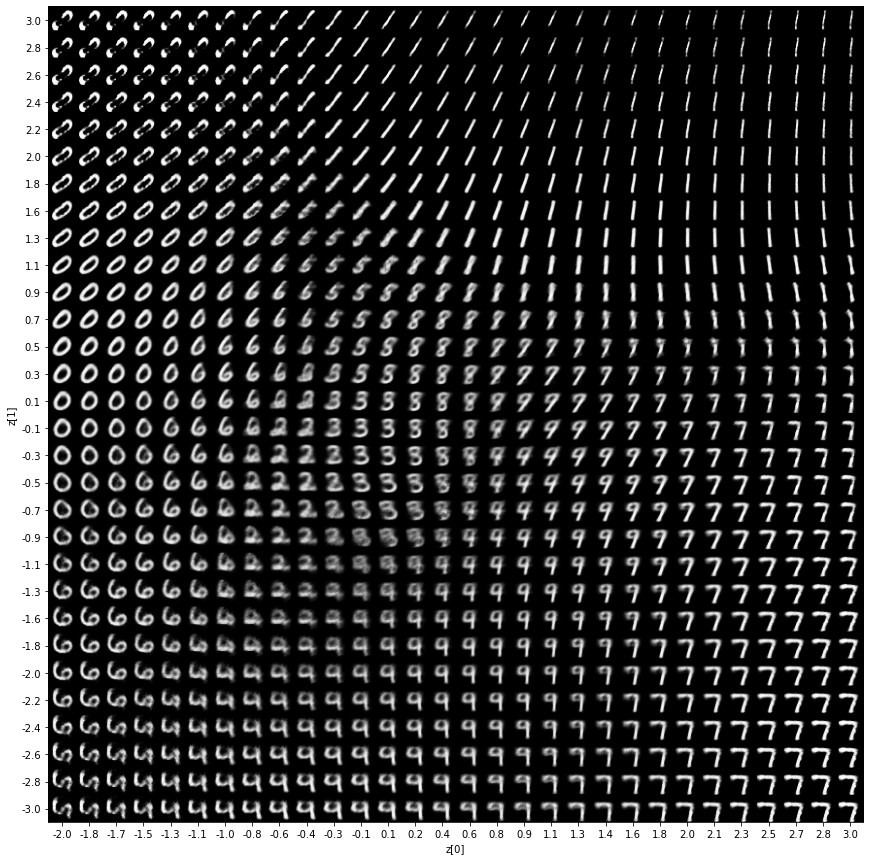

In [12]:
plot_latent_space(decoder, n=30, ranges=[-2, 3, -3, 3], figsize=15)

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.